### This notebook shows how to evaluate ANN classifiers with latent space performance metrics for ImageNet

In [1]:
import numpy as np
import torch
import torchvision.models as models
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
from latentspace.ml_util import *
import latentspace.datasets as datasets
import latentspace.generative as generative
import latentspace.cnn as cnn
from latentspace.adversarial_generation import *
from latentspace.evaluation_util import EvaluationUtil

### Load ImageNet validation data
It must be downloaded manually, check README.md.

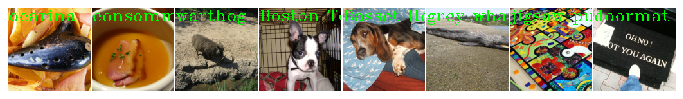

In [3]:
ds = datasets.ImageNetData()
loader = ds.get_test_loader(8)
images, labels = next(iter(loader))
Util.imshow_tensors(images, captions=ds.prediction_indices_to_printed_classes(labels), nrow=8)

### Load classifiers
The robust classifier ImageNet.pt must be downloaded manually. Check README.md.

In [4]:
from robustness import model_utils, datasets as robustness_datasets
dataset = robustness_datasets.ImageNet('./data/ImageNet')
model_kwargs = {'arch': 'resnet50', 'dataset': dataset, 'resume_path': f'./imagenet-models/ImageNet.pt'}
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model = model.to("cuda:0" if Util.using_cuda else "cpu")
model.eval();

=> loading checkpoint './imagenet-models/ImageNet.pt'
=> loaded checkpoint './imagenet-models/ImageNet.pt' (epoch 105)


### Load BigGAN
The pretrained model for BigGAN must be downloaded manually. Check README.md.

In [5]:
dataset_info = DatasetInfo.ImageNet
label_indices = np.arange(1000)
no_classes = len(label_indices)
classifier_d = "none"
gm = generative.BigGAN(ds, 0.25) # set built-in decay factor

*** Loading BigGAN...


In [7]:
# adapt the classifiers to the interface used in this project
# also take care of proper input normalization and resizing

class RobustnessClassifierWrapper(Trainer):
    def __init__(self, model):
        super().__init__(classifier_d, ds.get_train_loader, ds.get_test_loader, unit_type=0)
        self.model = torch.nn.Sequential(
            Resize(224),
            Lambda(lambda x: (x + 1) / 2),
            model,
            Lambda(lambda x: x[0]),
        )
        

class ModelZooClassifierWrapper(Trainer):
    modelzoo_normalize_transform = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )

    @staticmethod
    def normalize_modelzoo(x):
        # [-1, 1] -> [0, 1], then normalize
        # https://pytorch.org/docs/stable/torchvision/models.html
        return ModelZooClassifierWrapper.modelzoo_normalize_transform((x[0] + 1) / 2).unsqueeze(0)
    
    def __init__(self, model, side: int):
        super().__init__(classifier_d, ds.get_train_loader, ds.get_test_loader, unit_type=0)
        self.model = torch.nn.Sequential(
            Resize(side),
            Lambda(ModelZooClassifierWrapper.normalize_modelzoo),
            model,
        )

nonrobust_classifiers = [(models.squeezenet1_0, 256),   # original top-1 error 41.90%
                         (models.alexnet, 256),         # original top-1 error 43.45%
                         (models.resnet18, 224),        # original top-1 error 30.24%
                         (models.resnext50_32x4d, 224)] # original top-1 error 21.49%
classifiers = [ModelZooClassifierWrapper(Util.conditional_to_cuda(m(pretrained=True)), side)
               for m, side in nonrobust_classifiers] + [RobustnessClassifierWrapper(model)]

In [8]:
def advgen_experiments(adversary: Adversary, noise_eps: float, total_images: int):
    decay_factor = EpsDTransformer().eps_to_d(noise_eps)
    advgen = AdversarialGenerator(None, classifiers, True, decay_factor)
    advgen.set_generative_model(gm)
    for label in np.random.choice(label_indices, size=total_images):
        no_images = 1
        LogUtil.info(f"*** CLASS {label}: {ds.printed_classes[label]} ***")
        gm.configure_label(label)
        advgen.generate(adversary, no_images, True, clear_stat=False)
    LogUtil.info("*** STATISTICS ***")
    advgen.print_stats(True)

### Quick demonstration how generative models and classifiers work

* Show generated images for random classes.
* Reconstruction is slow and was not tuned to work well, but you are of course free to uncomment it. In subsequent cells, there will be no experiments with reconstruction.

*** CLASS 809: soup bowl ***


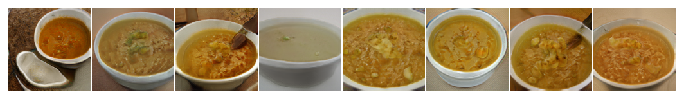

*** CLASS 353: gazelle ***


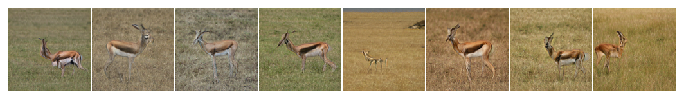

*** CLASS 490: chain mail ***


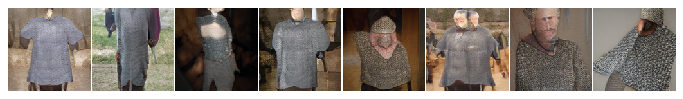

In [13]:
for label in np.random.choice(label_indices, size=3):
    LogUtil.info(f"*** CLASS {label}: {ds.printed_classes[label]} ***")
    gm.configure_label(label)
    EvaluationUtil.show_generated_images(gm, 1, 8)
    #EvaluationUtil.show_reconstructed_images(gm, 1, 4)

### Measure latent adversarial accuracy (LGA)

In [ ]:
advgen_experiments(NopAdversary(), noise_eps=1.0, total_images=100)

### Measure latent adversarial generation severity (LAGS) by searching for minimum latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of generated images
* Latent generation accuracy (LGA) is also computed
* Norms of minimum latent adversarial perturbations in the original space are also computed

In [ ]:
max_rho, noise_eps = 2.5, 1.0
adversary = PGDAdversary(max_rho, 50, 0.05, False, 0, verbose=0, n_repeat=12, repeat_mode="min")
advgen_experiments(adversary, noise_eps, total_images=100)

### Measure latent adversarial generation accuracy (LAGA) by searching for bounded latent adversarial perturbations

* Change the number of images to get more meaningful results
* Metric reports are after each series of reconstructed/generated images
* Latent generation accuracy (LGA) is also computed

In [ ]:
rho, noise_eps = 0.1, 1.0
adversary = PGDAdversary(rho, 50, 0.05, True, 0, verbose=0, n_repeat=12, repeat_mode="any")
advgen_experiments(adversary, noise_eps, total_images=100)